In [1]:
import sys
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("RPA_Test") \
    .getOrCreate()

In [2]:
# Acquisistion des données depuis une base de donnée SQL
"""database = "RobotWorkForce"
table = "(SELECT [workNumber],[templateID],[robotID],[receivedTime],[startTime],[endTime],isnull([MasterType].[resolutionTime]* 60,0) as 'ResolutionTimeObjective',[transactionTime],[status] FROM [dbo].[MasterLog] left join [MasterType] on [MasterLog].[templateID] = [MasterType].[id]) as MasterLog"
user = "XXXX"
password = "XXXX"

DF = spark.read.format("jdbc") \
    .option("url", f"jdbc:sqlserver://172.27.116.14:1433;databaseName={database};") \
    .option("dbtable",table) \
    .option("user",user) \
    .option("password", password) \
    .option("driver","com.microsoft.sqlserver.jdbc.SQLServerDriver") \
    .load()

table2 = "(SELECT [itemKey] as 'workNumber',[templateID],[RobotStatus].[id] as 'robotID',[scheduledTime] as 'receivedTime',[startTime],[endTime],isnull([MasterType].[resolutionTime] * 60,0) as 'ResolutionTimeObjective',abs(datediff(second,[startTime],[endTime])) as 'transactionTime',[status] FROM [Archived_RobotMasterLog] JOIN [RobotStatus] on [dbo].[RobotStatus].[RobotName] = [dbo].[Archived_RobotMasterLog].[robotName] left join [MasterType] on [Archived_RobotMasterLog].[templateID] = [MasterType].[id]) as MasterLogArch"
sDF2 = spark.read.format("jdbc") \
    .option("url", f"jdbc:sqlserver://172.27.116.14:1433;databaseName={database};") \
    .option("dbtable",table2) \
    .option("user",user) \
    .option("password", password) \
    .option("driver","com.microsoft.sqlserver.jdbc.SQLServerDriver") \
    .load()

#join des 2 tables
MasterLog = DF.unionAll(sDF2)
"""
# Acquisistion des données depuis un fichier parquet
MasterLog = spark.read.parquet("../data/logs/MasterLog")

In [3]:
#enregistratement du dataframe dans spark pour l'utiliser via les commandes SQL
MasterLog.createOrReplaceTempView("MasterLog")

In [4]:
#ajouter d'un Identifiant unique
from pyspark.sql.functions import *
df = spark.sql("SELECT workNumber, transactionTime, robotID, case when status = '' THEN 'unknown' ELSE status END as status FROM MasterLog WHERE templateID = 2311 and transactionTime < 13000")
df = df.withColumn("uniqueID",monotonically_increasing_id())

#retrait des valeurs null
df.na.drop()

DataFrame[workNumber: string, transactionTime: int, robotID: int, status: string, uniqueID: bigint]

In [5]:
#division du dataframe en traning et test
seed = 0
train, test = df.randomSplit([0.7,0.3],seed)

In [6]:
#Sting Indexer for Status
from pyspark.ml.feature import StringIndexer

stringIndexer1 = StringIndexer(inputCol="status",outputCol="statusIndex")
stringIndexer2 = StringIndexer(inputCol="robotID",outputCol="robotIndex")

In [7]:
#one Hot Encode Index
from pyspark.ml.feature import OneHotEncoder

oneHotEncoder1 = OneHotEncoder().setInputCol("statusIndex").setOutputCol("statusOneHot")
oneHotEncoder2 = OneHotEncoder().setInputCol("robotIndex").setOutputCol("robotOneHot")

In [8]:
#standard scaller
from pyspark.ml.feature import StandardScaler

standardScaler = StandardScaler(inputCol="features",outputCol="featuresScaled")

In [9]:
#Vector Assembler
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=['statusOneHot','robotOneHot','transactionTime'], outputCol="features")

In [10]:
#K-means
from pyspark.ml.clustering import KMeans

#use 6 Cluster
k = 6

kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")

In [11]:
#Pipeline Creation
from pyspark.ml import Pipeline
stages = [stringIndexer1,stringIndexer2,oneHotEncoder1,oneHotEncoder2,vecAssembler,kmeans]
pipeline = Pipeline().setStages(stages)

In [12]:
#Fitting the models using Parameters tuning, evaluation model and training validation split
kMeans_model = pipeline.fit(train)

In [13]:
#tranforming the models
transformed = kMeans_model.transform(df)

In [14]:
transformed = kMeans_model.transform(df).select('uniqueID', 'prediction','statusIndex')
rows = transformed.collect()
print(rows[:3])

[Row(uniqueID=8589934592, prediction=0, statusIndex=0.0), Row(uniqueID=8589934593, prediction=0, statusIndex=0.0), Row(uniqueID=8589934594, prediction=0, statusIndex=0.0)]


In [15]:
#join initial and final table on unique ID
df_pred = spark.createDataFrame(rows)

ta = df.alias('ta')
tb = df_pred.alias('tb')

join = ta.join(tb,ta.uniqueID == tb.uniqueID,how='left')
join.createOrReplaceTempView("MasterLog_Processed")
join.show(10)

+----------+---------------+-------+--------+----------+----------+----------+-----------+
|workNumber|transactionTime|robotID|  status|  uniqueID|  uniqueID|prediction|statusIndex|
+----------+---------------+-------+--------+----------+----------+----------+-----------+
|0000021160|            288|      5|Complete|8589934658|8589934658|         3|        0.0|
|0000011854|             57|      7|Complete|8589934965|8589934965|         0|        0.0|
|0000010905|             82|     10|Complete|8589935171|8589935171|         5|        0.0|
|0000011153|             70|     10|Complete|8589935183|8589935183|         0|        0.0|
|0000055624|             66|     10|Complete|8589935298|8589935298|         0|        0.0|
|0000056103|             96|      5|Complete|8589935317|8589935317|         5|        0.0|
|0000007693|             84|      9|Complete|8589935768|8589935768|         5|        0.0|
|0000007721|             84|     12|Complete|8589935770|8589935770|         5|        0.0|

In [16]:
#group per Cluster
df = spark.sql("SELECT count(*), avg(transactionTime), prediction FROM MasterLog_Processed GROUP BY prediction ORDER BY prediction")
df.show()

+--------+--------------------+----------+
|count(1)|avg(transactionTime)|prediction|
+--------+--------------------+----------+
|   88909|  58.539484191701625|         0|
|    1121|   484.6485280999108|         1|
|   17334|  154.52342217607014|         2|
|    4722|   312.8225328250741|         3|
|     328|   832.9451219512196|         4|
|   51476|   99.00575025254487|         5|
+--------+--------------------+----------+



In [17]:
#Output result to database
#set variable to be used to connect the database
"""database = "RobotWorkForce"
table = "dbo.Spark"
user = "XXXXX"
password  = "XXXXX"
 
#write the dataframe into a sql table
df.write.mode("overwrite") \
    .format("jdbc") \
    .option("url", f"jdbc:sqlserver://172.27.116.9:1433;databaseName={database};") \
    .option("dbtable",table) \
    .option("user",user) \
    .option("password", password) \
    .option("driver","com.microsoft.sqlserver.jdbc.SQLServerDriver") \
    .save()
"""

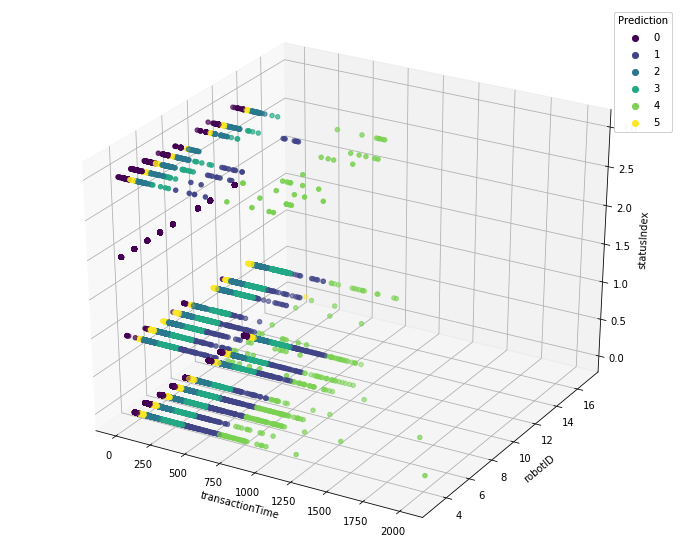

In [17]:
#Final display 
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#group per Cluster
df = spark.sql("SELECT workNumber, transactionTime, robotID, statusIndex, prediction FROM MasterLog_Processed")

pddf_pred = df.toPandas().set_index('workNumber')
pddf_pred.head()

ax = plt.figure(figsize=(12,10)).gca(projection='3d')
scatter = ax.scatter(pddf_pred.transactionTime, pddf_pred.robotID, pddf_pred.statusIndex, c=pddf_pred.prediction)
ax.set_xlabel('transactionTime')
ax.set_ylabel('robotID')
ax.set_zlabel('statusIndex')
legend1 = ax.legend(*scatter.legend_elements(),loc="upper right",title="Prediction")
ax.add_artist(legend1)
plt.show()

In [18]:
#end 
spark.stop()